# 패키지

In [30]:
!pip install seaborn
!pip install tqdm
!pip install -U scikit-learn
!pip install emoji
!pip install pyarrow
!pip install fastparquet
!pip install squarify
!pip install wordcloud

In [34]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import squarify
import tqdm
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Kkma, Hannanum
from collections import Counter
from emoji import core
from wordcloud import WordCloud
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Kkma = Kkma()
hannanum = Hannanum()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


-----------------------
# 함수

In [3]:
# dataframe에 있는 contents(본문)에 키워드 존재 여부 칼럼만들기
def keyword_search(df, key1):

    key1_list = []
    key2_list = []

    for i in df['contents']:
        if '아이스크림' in i:
            key1_list.append(True)

        else:
            key1_list.append(False)

    df[key1] = key1_list
    return df

In [4]:
# 전처리 함수 1 : point_reduce
# 점이 여러개 찍혀있는 것을 한개로 바꿈

def point_reduce(sentence):
    while True:
        try:
            if '..' in sentence:
                sentence = sentence.replace('..','.')
            
            else:
                sentence = sentence.replace('.','. ') # 온점 뒤에 space 넣어뒀음. 불필요시 제거.
                if '  ' in sentence:
                    sentence = sentence.replace('  ',' ')
                    # print(sentence)
                    return sentence
                    break
                else:
                    return sentence
        except:
            return sentence
        
        # if '  ' not in sentence:
        #     break

In [5]:
# 문장 단위로 끊기
def classify_sentence(sentence):
    sentence_list = sentence.split('. ')
    if ' ' in sentence_list:
        sentence_list.remove(' ')
        return sentence_list

    else:
        return sentence_list

In [6]:
# dummy 없애기 (밀크티 관련만 남기기)

def search_milkT(text):
    if "밀크티" in text:
        return True

    elif "밀크t" in text.lower():
        return True
            
    elif "milkT" in text.lower():
        return True
    
    elif "ㅁㅋㅌ" in text:
        return True

    # elif "학습" in text:
    #     return True

    else:
        return False

In [7]:
# 광고 여부 확인하기

def check_ad(text):
    if '광고' in text:
        return True
    
    elif '추천인' in text:
        return True

    elif '서포터' in text:
        return True

    else:
        return False

In [8]:
# 주어 찾기 함수

def subject_extraction(text):
    
    # 형태소 분석
    pos = Kkma.pos(text)

    # 주어 추출
    for i in range(len(pos)):
        if pos[i][1] == 'NNG':  # 명사
            if i == 0 or (i > 0 and pos[i-1][1] != 'NNG'):  # 주어는 문장 첫 단어이거나 앞 단어가 조사가 아닌 경우
                return pos[i][0]
                break

In [9]:
# 키워드가 주어인 본문 정리하기
## keword에서 다음 keyword 까지의 text 추출


def gather_sentence(text, key1, key2):

    text_list = text.split('.') # 문장 단위 : "."

    while ' ' in text_list: # '' 안에 text가 들어있지 않으면 error가 발생함을 방지
        text_list.remove(' ')

    key1_paragraph = []
    key2_paragraph = []
    for i in range(len(text_list)):
        if subject_extraction(text_list[i]) == key1:
            plus_num = 1
            # milk_para.append(text_list[i])
            sentence = text_list[i]
            # print(f'{key1}파트 {i}번째 진행중')
            while i+plus_num < len(text_list):
                if subject_extraction(text_list[i+plus_num]) == key1 or subject_extraction(text_list[i+plus_num]) == key2:
                    # print(f'!! 스캔 {key1}파트 종료')
                    break
                
                else:
                    # milk_para.append(text_list[i+plus_num])
                    if i+plus_num > len(text_list):
                        # print(f'!! 스캔 {key1}파트 종료')
                        break
                    else:
                        sentence = sentence + '' + text_list[i+plus_num]
                        plus_num += 1
                        # print(f'!! 스캔 {key1}파트 {i+plus_num}번째 진행중')

            key1_paragraph.append(sentence)

        else:
            pass

        if subject_extraction(text_list[i]) == key2:
            plus_num = 1
            # milk_para.append(text_list[i])
            sentence = text_list[i]
            # print(f'{key2}파트 {i}번째 진행중')
            while i+plus_num < len(text_list):
                if subject_extraction(text_list[i+plus_num]) == key1 or subject_extraction(text_list[i+plus_num]) == key2:
                    break
                
                else:
                    # milk_para.append(text_list[i+plus_num])
                    sentence = sentence + '' + text_list[i+plus_num]
                    plus_num += 1

            key2_paragraph.append(sentence)

        else:
            pass

    if key1_paragraph == []:
        for i in range(len(text_list)):
            pos_list = Kkma.pos(text_list[i])
            if (key1, 'NNG') in pos_list:
                key1_paragraph.append(text_list[i])

    if key2_paragraph == []:
        for i in range(len(text_list)):
            pos_list = Kkma.pos(text_list[i])
            if (key2, 'NNG') in pos_list:
                key2_paragraph.append(text_list[i])
    else:
        pass
    
    return {key1 : key1_paragraph, key2 : key2_paragraph}

In [59]:
# 명사, 동사 추출

def extract_func(dict):
    key1 = list(dict.keys())[0]
    key2 = list(dict.keys())[1]
    key1_list = []
    key2_list = []

    for i in range(len(dict[key1])):
        pos = Kkma.pos(dict[key1][i])
        for j in pos:
            if j[1] == 'VA': #동사
                key1_list.append(j[0]+'다')
            if j[1] == 'NNG':
                key1_list.append(j[0])

    for i in range(len(dict[key2])):
        pos = Kkma.pos(dict[key2][i])
        for j in pos:
            if j[1] == 'VA': #동사
                key2_list.append(j[0]+'다')
            if j[1] == 'NNG':
                key2_list.append(j[0])

    frequncy_dict = {key1 : key1_list, key2 : key2_list}

    return frequncy_dict

-------------------------
# 코드

In [11]:
# dataframe 불러오기 및 전처리

# csv파일 불러오기
df = pd.read_csv('./test_blog_crawling.csv') 

# 크롤링 실패한 raw, 불필요한 column 삭제
df = df[df['Title'] != 'Error']
df.reset_index(drop=True, inplace=True)
df = df.drop(['Title', 'Unnamed: 0'], axis=1)

# 정규식
df.contents = df.contents.apply(lambda x : re.sub('[-=+,#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\n★▲;]','', x))
df.contents = df.contents.apply(lambda x : re.sub('\W. ','',x))

# 이모티콘 제거
df.contents = df.contents.apply(lambda x : core.replace_emoji(x, replace=''))

# 문장단위로 분리
df['contents'] = df['contents'].apply(lambda x: point_reduce(x))
df['contents_list'] = df['contents'].apply(lambda x: classify_sentence(x))

# dummy 없애기 2 (학습과 관련된 데이터만 남기기 ('학습', '선생'))

df['Check_milkT'] = df['contents'].apply(lambda x : search_milkT(x))
df['check_test'] = df['contents'].apply(lambda x : '학습' in x and '선생' in x)

# df.Check_milkT.value_counts()
# df['check_test'].value_counts()

df = df[df['check_test'] == True]
df = df[df['Check_milkT'] == True]

df['recommend'] = df['contents'].apply(lambda x : check_ad(x))
df = df.drop(['Check_milkT', 'check_test'], axis=1)
df.reset_index(drop=True, inplace=True)

df.drop('contents_list', axis=1, inplace=True)
df = keyword_search(df, '아이스크림')
df = keyword_search(df, '엘리하이')

,contents,recommend,아이스크림,엘리하이
0,3학년 때부터 밀크T 수업을 시작했고 2년 약정으로 시작해서연장함. 연장해서 1년이...,False,False,False
1,밀크티패드를 시작한지 2개월을 채워가는 중이네요 작년 12월급한 마음에 바로 정회원...,True,False,False
2,밀크T 친구 추천 이벤트밀크티 학습지 남매 2년 사용 연장 후기3월9일수정 해요2월...,True,True,True
3,새학기 되면서 아이들 학원 스케줄 짜느라 분주한 분들 많으시죠. 저는 올해 중학생이...,True,False,False
4,연두는 현재 6학년으로 예비중등입니다. 저학년 때부터 밀크티에 정착했는데요영어 수학...,False,False,False
...,...,...,...,...
118,새로운 선생님과 친구들을 만날 생각에 신이 나서 개학을 기다렸는데학교도 개학이 연기...,False,True,True
119,이제 3학년이 되는 아드님은 오늘도 열심히 밀크T학습을 하면서 학습을 진행하고 있어...,False,False,False
120,초등인강 추천아이 눈높이에 딱요 며칠간 아이들이 정말 신나 보였어요. 이렇게 신나있...,False,False,False
121,안녕하세요. 강북구과외 선생님입니다. 학생들을 지도한지 5년 정도 되었습니다. 강북...,False,False,False


In [21]:
# dict_list = []

# for i in range(len(df.contents)):
#     print(f'{i}번째 실행중')
#     dict_list.append(gather_sentence(df.contents[i], '밀크', '홈런'))

In [14]:
# key1 = '홈런'
# key2 = input('find keyword')
# 이모티콘 같은 특수기호가 들어가 있으면 에러발생...

df['keyword_dict'] = df['contents'].apply(lambda x : gather_sentence(x, '밀크', '홈런'))

In [49]:
df.head()

,contents,recommend,아이스크림,엘리하이,keyword_dict
0,3학년 때부터 밀크T 수업을 시작했고 2년 약정으로 시작해서연장함. 연장해서 1년이...,False,False,False,{'밀크': [' 밀크T 초등 2020년에 시작할갤럭시탭 A6를 기계로 받았다지금은...
1,밀크티패드를 시작한지 2개월을 채워가는 중이네요 작년 12월급한 마음에 바로 정회원...,True,False,False,{'밀크': ['밀크티패드를 시작한지 2개월을 채워가는 중이네요 작년 12월급한 마...
2,밀크T 친구 추천 이벤트밀크티 학습지 남매 2년 사용 연장 후기3월9일수정 해요2월...,True,True,True,{'밀크': ['밀크T 친구 추천 이벤트밀크티 학습지 남매 2년 사용 연장 후기3월...
3,새학기 되면서 아이들 학원 스케줄 짜느라 분주한 분들 많으시죠. 저는 올해 중학생이...,True,False,False,{'밀크': [' ㅎㅎ밀크티 초등 내용밀크티 초등은 국어 수학 영어 사회 과학 봄여...
4,연두는 현재 6학년으로 예비중등입니다. 저학년 때부터 밀크티에 정착했는데요영어 수학...,False,False,False,{'밀크': [' 밀크T 바로 가기본 포스팅은 천재교육 밀크T로부터 학습기기소정의 ...


In [60]:
extract_func(df.keyword_dict[2])

{'밀크': ['밀크',
  '친구',
  '추천',
  '이벤트',
  '밀크',
  '티',
  '학습지',
  '남매',
  '사용',
  '연장',
  '후기',
  '수정',
  '해',
  '상품권',
  '이벤트',
  '이벤트',
  '원권',
  '행사',
  '해',
  '아래',
  '카카오',
  '채팅',
  '주시',
  '추천인',
  '링크',
  '년',
  '밀크',
  '티',
  '학습지',
  '홈런',
  '최종',
  '결정',
  '둘',
  '체험',
  '밀크',
  '티',
  '최종',
  '결정',
  '한지',
  '엊그제',
  '같다',
  '시간',
  '빠르다',
  '신청',
  '회원',
  '추천',
  '시작',
  '하세',
  '새해',
  '이벤트',
  '기간',
  '얼마',
  '안',
  '학습',
  '테',
  '추천인',
  '가능',
  '추천인',
  '아이디',
  '상품권',
  '약정',
  '신청',
  '시',
  '할인',
  '형제',
  '자매',
  '시',
  '추가',
  '할인',
  '교제',
  '천재',
  '교육',
  '도서',
  '상품권',
  '다양',
  '혜택',
  '마세',
  '밀크',
  '티',
  '이쪽',
  '채팅',
  '주시',
  '추천인',
  '링크',
  '정회원',
  '링크',
  '신청',
  '등록',
  '채팅',
  '주시',
  '추천인',
  '링크',
  '학',
  '습',
  '회원',
  '추천인',
  '시',
  '왕',
  '추가',
  '밀크',
  '티',
  '아이스크림',
  '홈런',
  '학습지',
  '무료',
  '체험',
  '밀크',
  '티',
  '아이스크림',
  '홈런',
  '학습지',
  '비교',
  '체험',
  '올해',
  '초등학생',
  '아들',
  '사교육',
  '아이',
  '동안',
  '재미있다',
  '밀크',
  '티',
  '학

In [61]:
milk_list = []
homerun_list = []

for i in df['keyword_dict']:
    extract = extract_func(i)
    milk_list = milk_list + extract['밀크']
    homerun_list = homerun_list + extract['홈런']

In [18]:
len(milk_list)

0

In [19]:
len(homerun_list)

0

In [62]:
milk_nouns_counter = Counter(milk_list)
top_milk_nouns = dict(milk_nouns_counter.most_common(100))
top_milk_nouns

{'밀크': 1569,
 '학습': 1121,
 '티': 1063,
 '아이': 839,
 '초등': 512,
 '체험': 418,
 '천재': 362,
 '추천인': 352,
 '교육': 329,
 '선생님': 310,
 '혜택': 308,
 '같다': 305,
 '좋다': 296,
 '상품권': 273,
 '공부': 268,
 '무료': 239,
 '영어': 221,
 '신청': 215,
 '문제': 207,
 '추천': 202,
 '없다': 199,
 '학년': 193,
 '수업': 189,
 '가능': 188,
 '수학': 181,
 '때': 178,
 '가입': 174,
 '교과서': 153,
 '사용': 148,
 '학습지': 147,
 '선택': 147,
 '부분': 146,
 '생각': 140,
 '강': 140,
 '많다': 139,
 '이벤트': 139,
 '기기': 137,
 '수': 129,
 '엄마': 129,
 '정회원': 127,
 '가격': 125,
 '연장': 122,
 '인': 122,
 '시간': 120,
 '자동': 119,
 '추가': 117,
 '강의': 116,
 '패드': 109,
 '분': 106,
 '할인': 105,
 '확인': 104,
 '글': 102,
 '한글': 101,
 '내용': 100,
 '관리': 100,
 '상담': 99,
 '시작': 96,
 '약정': 96,
 '컨텐츠': 96,
 '기간': 95,
 '평가': 95,
 '아이디': 94,
 '경우': 94,
 '콘텐츠': 94,
 '시': 93,
 '재미있다': 93,
 '학교': 92,
 '다양': 92,
 '오늘': 91,
 '후기': 89,
 '정도': 87,
 '게임': 86,
 '진행': 83,
 '지금': 82,
 '학원': 82,
 '전': 82,
 '필요': 81,
 '과목': 81,
 '홈런': 80,
 '방학': 80,
 '주세': 79,
 '결제': 77,
 '마음': 77,
 '질': 76,
 '정': 75,
 '옵션':

In [67]:
currentpath = os.getcwd()
currentpath

'c:\\Users\\user\\Documents\\YE\\project\\naver_api'

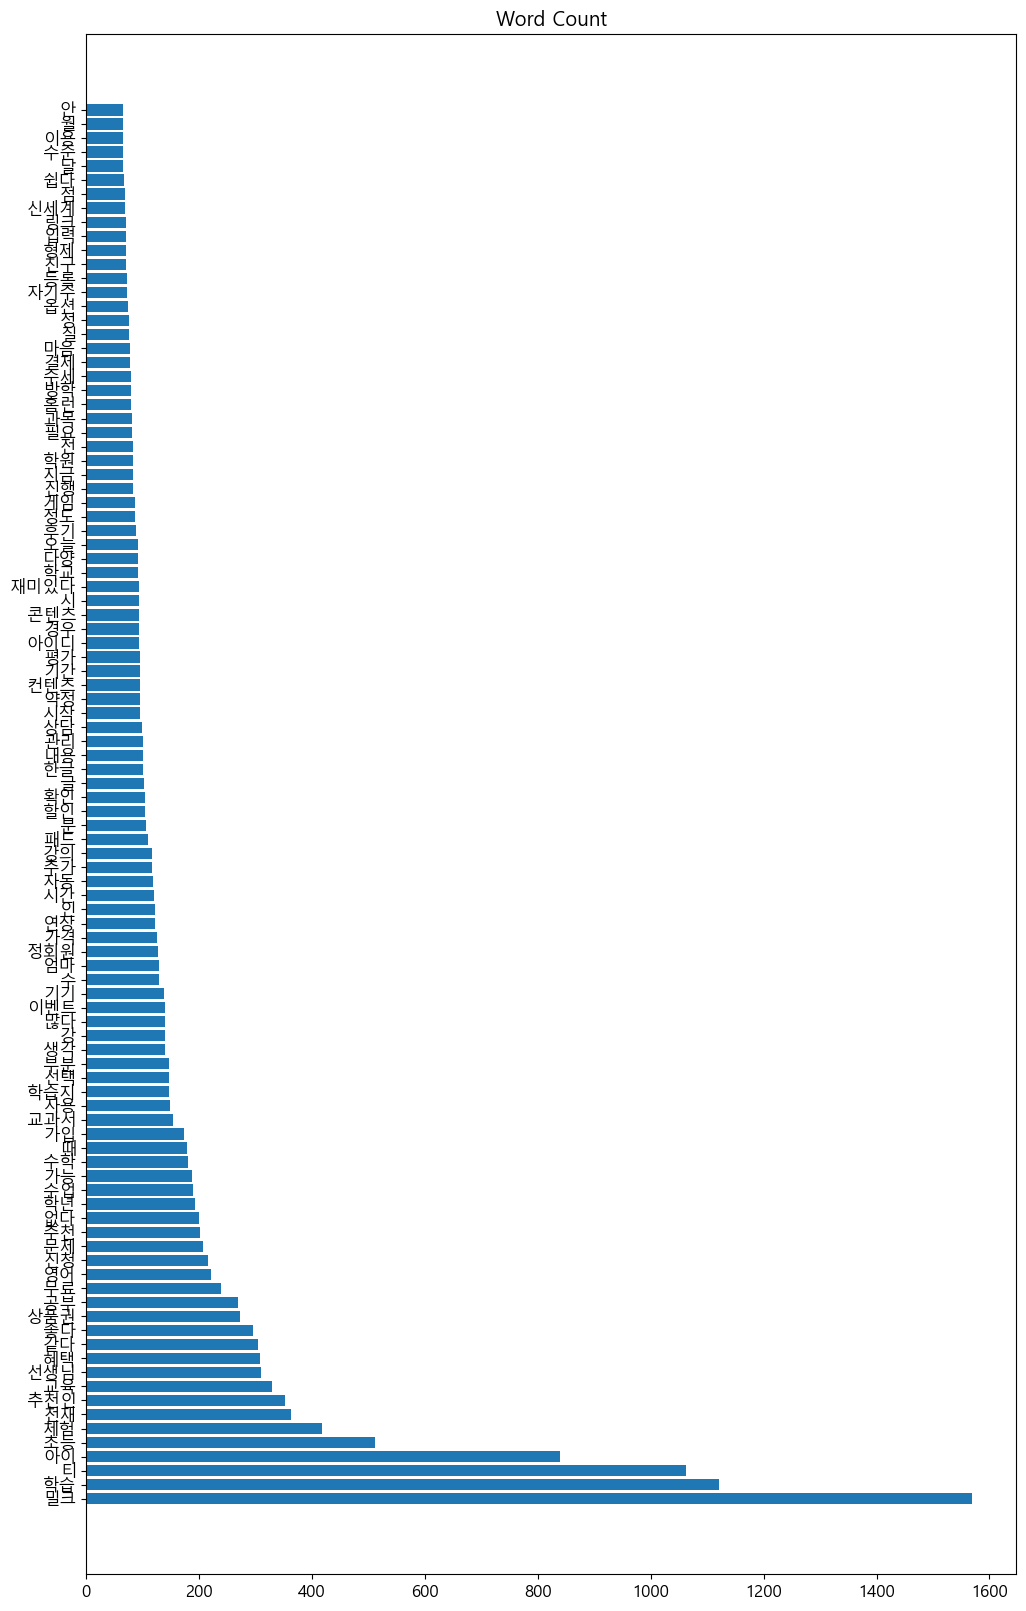

In [63]:
plt.rcParams['font.size'] = 12

y_pos = np.arange(len(top_milk_nouns))

plt.figure(figsize=(12, 20))
plt.barh(y_pos, top_milk_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_milk_nouns.keys())
plt.show()

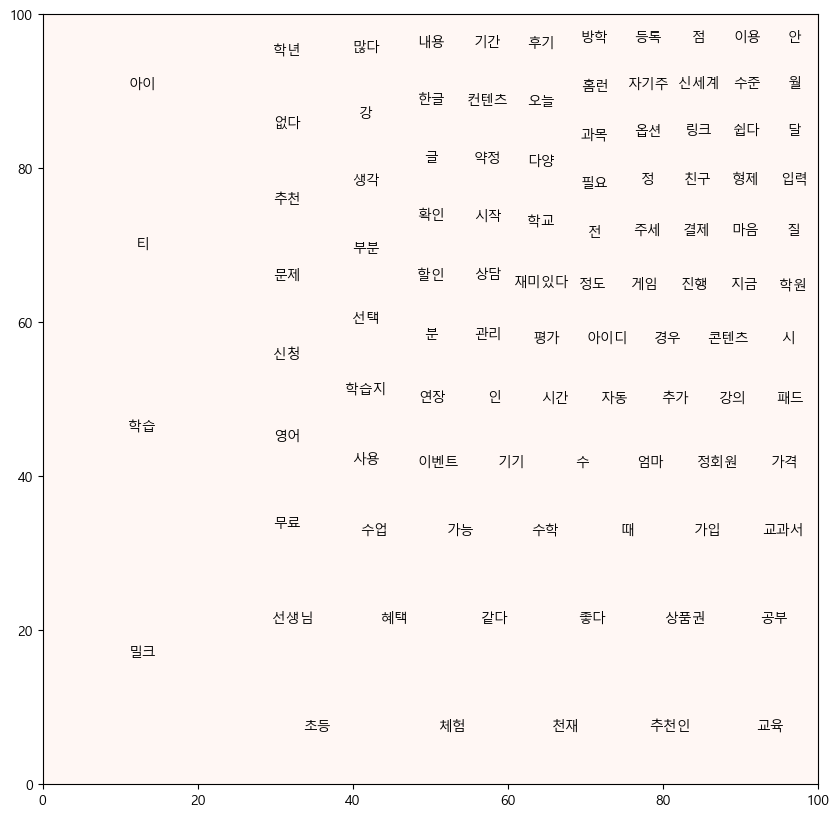

In [64]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 10

norm = mpl.colors.Normalize(vmin = min(top_milk_nouns.values()),
                            vmax = min(top_milk_nouns.values()))

colors = [mpl.cm.Reds(norm(value)) for value in top_milk_nouns.values()]

squarify.plot(label=top_milk_nouns.keys(),
              sizes=top_milk_nouns.values(),
              color=colors,
              alpha=.7);

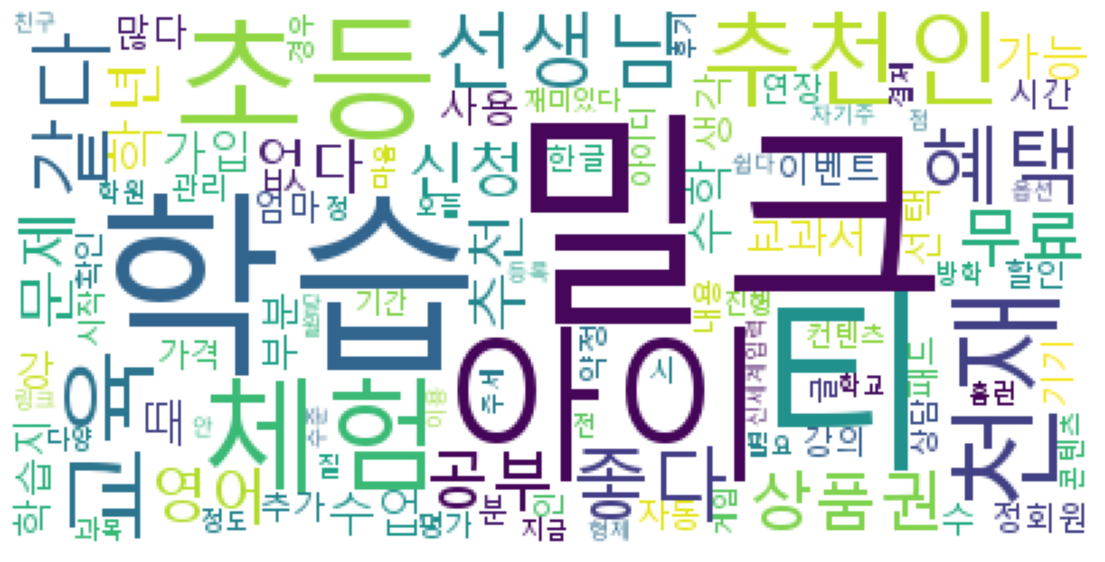

In [65]:
wc = WordCloud(background_color='white', font_path='C:/Windows/Fonts/malgun.ttf')
wc.generate_from_frequencies(top_milk_nouns)

figure = plt.figure(figsize = (14,14))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

In [ ]:
corpus = ['밀크T 수업을 시작하고 1년이 지났다. 연장은 2년을 하였으며 처음엔 수학과목만 생각해서 시작을 했는데 홈런보다 영어 컨텐츠가 더 좋은 것 같아서 연장했다. 학교가기 전에 밀크티로 예습하면 수업이 재미있다고 한다. 아이들 말로는 홈런은 캐릭터가 재미있다고 한다. 홈런이 캐릭터 하나는 기가막히게 만드나보다. 혹시라도 홈런과 밀크티를 고민하는 분이 있으면 이 글을 참고해보세요.']
print(corpus)

vector = CountVectorizer()
bow = vector.fit_transform(corpus)

print(bow.toarray())
print(vector.vocabulary_)